In [1]:
import os
from pathlib import Path
import shutil
from distutils.dir_util import copy_tree

import pandas as pd
import json
import time
import datetime
from PIL import Image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import scipy.stats
import itertools

# https://github.com/qwirky-yuzu/COCO-to-YOLO/blob/main/coco_to_yolo.py
# https://github.com/pylabel-project/samples/blob/main/coco2yolov5.ipynb
try:
    import pylabel
except:
    !pip install pylabel
finally:
    from pylabel import importer

import matplotlib.patches as patches
import matplotlib
import matplotlib.colors as mcolors

plt.rcParams.update({'font.size': 22})
style_label = 'fivethirtyeight' #plt.style.available 

In [3]:
import labelutilits as utl

In [4]:
try:
    import dsatools 
except:
    !pip install dsatools
finally:
    import dsatools.utilits as ut

In [5]:
path = os.getcwd() 
print(utl.list_dirs(path))
pt_ = os.path.join(path, utl.list_dirs(path)[2])
utl.print_dir_description(pt_)

['labelutilits', 'part1', 'part2', 'part3', 'part4', 'part5', 'part6', 'part7', 'part8', 'part9']
dirs []
content {'images': 225, 'dirs': 0, 'json': 1, 'xml': 1, 'csv': 0, 'txt': 0, 'other': 0}
not content []
anno cvat ['part2.json']
anno xml ['annotations.xml']
cnt img content 225


In [6]:
dir_no = 2
dir_name = utl.list_dirs(path)[dir_no]


pt_ = os.path.join(path, dir_name)
anno_file = utl.list_json(pt_)[0]
anno_path = os.path.join(pt_, anno_file)

print(anno_path)

D:\ASBEST!\ALLVEINS\part2\part2.json


In [7]:
df = utl.correct_anno_img_names(anno_path, image_dir_path=None, image_id = None)

In [8]:
labeld_image_ids = utl.check_anno_labels(anno_path, cat_ids = None)
labeld_image_ids

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


[143, 170, 178, 191, 193, 219, 224]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
anno path:  D:\ASBEST!\ALLVEINS\part2\part2.json
image path is  ['D:\\ASBEST!\\ALLVEINS\\part2\\11-15-18_1_.bmp']
n instances for image =  0


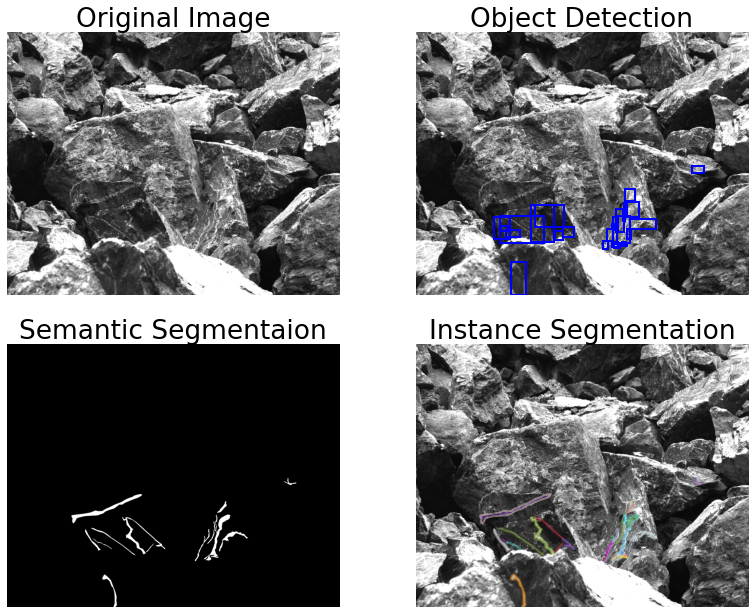

{'name': 'part2', 'anno_path': 'D:\\ASBEST!\\ALLVEINS\\part2\\part2.json', 'anno_fname': 'part2.json', 'image_dir_path': 'D:\\ASBEST!\\ALLVEINS\\part2', 'length': 225, 'anno_number': 120, 'class_id': [1, 2], 'class_names': ['stone', 'asbest'], 'height': [2048], 'width': [2592], 'COCO_obj': <pycocotools.coco.COCO object at 0x000001F9C4192A20>, 'dataset_keys': dict_keys(['licenses', 'info', 'categories', 'images', 'annotations']), 'anno_keys': dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes']), 'image_keys': dict_keys(['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured']), 'image_fname_example': '11-15-18_1_.bmp'}


In [9]:
anno = utl.Annotation(anno_path,image_dir_path=None)
print('anno path: ',anno.anno_path)
print('image path is ',anno.get_image_pathes(image_id=[1]))
print('n instances for image = ', len(anno.get_anno_image(image_id = [1])))

# plt.imshow(anno.get_image(image_id=[3]));plt.show()
anno.plot_all_anno(image_id=[170], cat_ids=[2], figsize=(12, 9))
print(anno.coco_anno_dict)

In [10]:
import labelutilits as utl

In [32]:
#----------------------------------------------
def check_anno_labels(anno_path, image_dir_path = None, cat_ids = None):
    '''
    Check images with labels in annotation file.

    Parameters
    ----------
    anno_path: string, 
      path annotation file.
    image_dir_path: string,
      path iamge directory; 
      if none anno file and images are in the same directory. 
    cat_ids: list[int],
      classes to outout.

    Returns
    ----------
    list[int],
      list of image ids with labels.
    '''
    coco_anno_dict,  coco, image_dir_path = anno2coco(anno_path, image_dir_path)
    return _check_anno_labels(coco_anno_dict, coco, cat_ids)

def _check_anno_labels(coco_anno_dict, coco, cat_ids = None):
    ''' Check images with labels in annotation file.'''
    anno =  _get_coco_annotations(coco_anno_dict,  coco, image_id = None, cat_ids = cat_ids)
    labeld_image_ids = {annoi['image_id'] for annoi in anno}
    return sorted(list(labeld_image_ids))
#----------------------------------------------

def anno2df(anno_path, image_dir_path=None, cat_ids = None, start_image_id = 0, start_anno_id = 0):
    ''' 
    Create dataframe with existed label description,
    such to merge them into new anno_file.
        
    anno_path: string, 
      path annotation file.
    image_dir_path: string,
      path iamge directory. 
      if none anno file and images are in the same directory. 
    cat_ids: list[int],
      classes to outout.
    start_image_id: int,
      first id number of the new image description
    start_anno_id: int,
      first id number of the new annotation description
    Returns
    ----------
    pd.DataFrame{},
      DataFrame with new description.  Keys of Frame:
       'new_image_id':  int, new image ID number,
       'old_image_id':  int, old image ID number,
       'old_anno_ids' : list[int], old annotation ID number,
       'new_anno_ids' : list[int], new annotation ID number,
       'old_file_name': string, expected file_name without image dir,
       'new_file_name': string, expected file_name with image dir,
       'img_desc':      dict, descriptor of iamge in COCO format,
       'anno':          list[dict], descriptor of annotations in COCO format,
        
    '''
    coco_anno_dict,  coco, image_dir_path  = anno2coco(anno_path, image_dir_path=image_dir_path)

    if cat_ids == None: cat_ids = coco_anno_dict['class_id']

    labeld_image_ids = _check_anno_labels(coco_anno_dict, coco, cat_ids = cat_ids)
    # labeld_image_ids = check_anno_labels(anno_path, cat_ids = None)

    imglist = coco.loadImgs(ids=labeld_image_ids)

    df = pd.DataFrame()

    for i,img_desc in enumerate(imglist):

        anno_ids = coco.getAnnIds(imgIds =[img_desc['id']], 
                                  catIds=cat_ids, 
                                  iscrowd=None)

        anno = coco.loadAnns(anno_ids) 

        dict_desc = {'new_image_id':  int(i + start_image_id + 1),
                     'old_image_id':  int(img_desc['id']),
                     'old_anno_ids':  anno_ids,
                     'new_anno_ids':  [anno_id + start_anno_id for anno_id in anno_ids],
                     'old_file_name': img_desc['file_name'],
                     'new_file_name': os.path.join(image_dir_path, img_desc['file_name']),}

        img_desc['id'] = dict_desc['new_image_id']
        img_desc['file_name'] = dict_desc['new_file_name']

        for i, anno_id in enumerate(dict_desc['new_anno_ids']):
            anno[i]['image_id'] = img_desc['id']
            anno[i]['id']       = anno_id

        dict_desc = {**dict_desc, 
                     'img_desc':img_desc, 
                     'anno':anno}

        df = df.append(dict_desc, ignore_index=True)
    return df

In [ ]:
anno2df(anno_path, image_dir_path=None, cat_ids = None, start_image_id = 0, start_anno_id = 0)

In [30]:
def _last_from_annodf(annodf):
    ''' Auxiliary for anno df: return last image id and alast annotation id.
    '''
    last_anno_id = annodf['new_anno_ids'].iloc[-1][-1]
    last_image_id = annodf['new_image_id'].iloc[-1]
    return last_anno_id,  last_image_id


def collec_newanno(path, dir_names):
    last_anno_id,  last_image_id = 0,0
    annodf = pd.DataFrame()
    for dir_name in dir_names:
        print(dir_name)
        pt_ = os.path.join(path, dir_name)
        anno_file = utl.list_json(pt_)[0]
        anno_path = os.path.join(pt_, anno_file)

        df = utl.correct_anno_img_names(anno_path, image_dir_path=None, image_id = None)
        print(last_anno_id,  last_image_id)
        info = utl.anno_info(anno_path, image_dir_path = None)
        print(info['length'],info['anno_number'])
        print(10*'--')
        annodf = utl.anno2df(anno_path, start_image_id = last_image_id, start_anno_id = last_anno_id, image_dir_path=None, cat_ids = None)
       
        if annodf.shape[0] >0:
            last_anno_id,  last_image_id = _last_from_annodf(annodf)
            annodf = annodf.append(annodf,ignore_index=True)
            print(last_anno_id,  last_image_id)
    return annodf

In [31]:
path = os.getcwd() 
dir_names = utl.list_dirs(path)[1:]
print(dir_names)
annodf = collec_newanno(path, dir_names)

['part1', 'part2', 'part3', 'part4', 'part5', 'part6', 'part7', 'part8', 'part9']
part1
0 0
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
316 1736
--------------------
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
1736 69.0
part2
1736 69.0
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
225 120
--------------------
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
1856 76.0
part3
1856 76.0
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
442 512
--------------------
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2357 129.0
part4
2357 129.0
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
58 0
--------------------
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
part5
2357 129.0
loading annotations into memory..

In [25]:
annodf.iloc[-1]

anno             [{'id': 4221, 'image_id': 249, 'category_id': ...
img_desc         {'id': 249, 'width': 2592, 'height': 2048, 'fi...
new_anno_ids     [4221, 4222, 4223, 4224, 4225, 4226, 4227, 422...
new_file_name    D:\ASBEST!\ALLVEINS\part9\ManualGeneralImage_0...
new_image_id                                                   249
old_anno_ids     [1433, 1434, 1435, 1436, 1437, 1438, 1439, 144...
old_file_name                      ManualGeneralImage_09_36_44.bmp
old_image_id                                                    56
Name: 111, dtype: object

In [ ]:
path = os.getcwd() 
print(utl.list_dirs(path))
last_anno_id,  last_image_id = 0,0
annodf = pd.DataFrame()

dir_names = utl.list_dirs(path)
dir_no = 2
dir_name = utl.list_dirs(path)[dir_no]



# with open(anno_path) as json_file:
#     data = json.load(json_file)
#     json_file.close()
    
# new_annos  = sum(df['anno'].tolist(),[])
# new_images = df['img_desc'].tolist()

# data['images']      = new_images
# data['annotations'] = new_annos




In [ ]:
df = utl.anno2df(anno_path, start_image_id = 0, start_anno_id = 0, image_dir_path=None, cat_ids = None)
df.sample(1)

In [ ]:
def _last_from_annodf(annodf):
    last_anno_id = annodf['new_anno_ids'].iloc[-1][-1]
    last_image_id = annodf['new_image_id'].iloc[-1]
    return last_anno_id,  last_image_id



In [ ]:
cats_ids = sorted(list({new_anno['category_id'] for new_anno in new_annos}))
cats_ids = [1,2]

In [9]:
new_annos  = sum(df['anno'].tolist(),[])

KeyError: 'anno'

In [10]:
new_images = df['img_desc'].tolist()

KeyError: 'img_desc'

In [11]:
data['images']      = new_images
data['annotations'] = new_annos

NameError: name 'new_images' is not defined

In [12]:
with open(anno_path) as json_file:
    data = json.load(json_file)
    json_file.close()
print(data.keys())


dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])


In [13]:
# data['images']

In [14]:
print(data['annotations'][0].keys())
print(df['anno'][0][0].keys())
print(data['images'][0].keys())
print(df['img_desc'][0].keys())

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes'])


KeyError: 'anno'

In [23]:
data['categories']

[{'id': 1, 'name': 'stone', 'supercategory': ''},
 {'id': 2, 'name': 'asbest', 'supercategory': ''}]